In [126]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from pyresample import geometry
import random
from skimage.transform import resize
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)

In [76]:
landsat_path = '../landsat_files/landsat_files/'
goes_path = '../landsat_files/'
goes039 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C07_G17_s20212401846176_e20212401848561_c20212401849003.npy')
goes103 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C14_G17_s20212401846176_e20212401848549_c20212401848593.npy')

In [4]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
pc_extents = [-124.25, 32.25, -114.25, 42.25]
shape = [500, 500]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

latlon1A = [40.49, -121.45]
latlon2A = [40.650000000000006, -121.17]
coords1A = target_area.get_array_coordinates_from_lonlat(latlon1A[1], latlon1A[0])
coords1A = (round(coords1A[0]), round(coords1A[1]))
coords2A = target_area.get_array_coordinates_from_lonlat(latlon2A[1], latlon2A[0])
coords2A = (round(coords2A[0]), round(coords2A[1]))
lonsA = [coords1A[0], coords2A[0]]
latsA = [coords2A[1], coords1A[1]]

latlon1B = [39.91, -120.97]
latlon2B = [40.13, -120.49000000000001]
coords1B = target_area.get_array_coordinates_from_lonlat(latlon1B[1], latlon1B[0])
coords1B = (round(coords1B[0]), round(coords1B[1]))
coords2B = target_area.get_array_coordinates_from_lonlat(latlon2B[1], latlon2B[0])
coords2B = (round(coords2B[0]), round(coords2B[1]))
lonsB = [coords1B[0], coords2B[0]]
latsB = [coords2B[1], coords1B[1]]

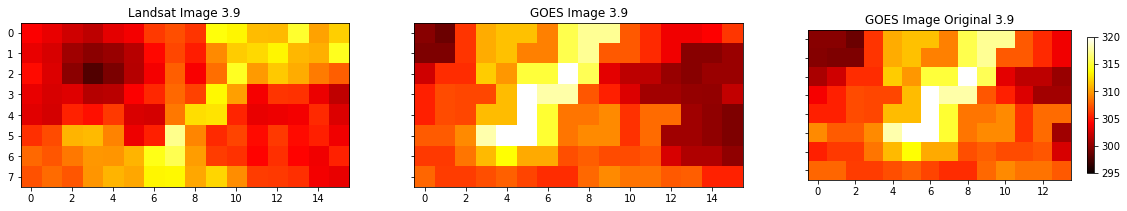

In [90]:
landsat_img_039 = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.02deg.npy'))
goes_img_039 = shiftPixels(landsat_img, goes039, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_original_039 = goes039[latsA[0]:latsA[1], lonsA[0]:lonsA[1]]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
max_temp = 320
min_temp = 295
landsat_map = ax1.imshow(landsat_img_039, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1.set_title('Landsat Image 3.9')
goes_map = ax2.imshow(goes_img_039, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2.set_title('GOES Image 3.9')
goes_original_map = ax3.imshow(goes_img_original_039, vmin = min_temp, vmax = max_temp, cmap='hot')
ax3.set_title('GOES Image Original 3.9')
plt.colorbar(landsat_map, ax = ax3, shrink=0.25)

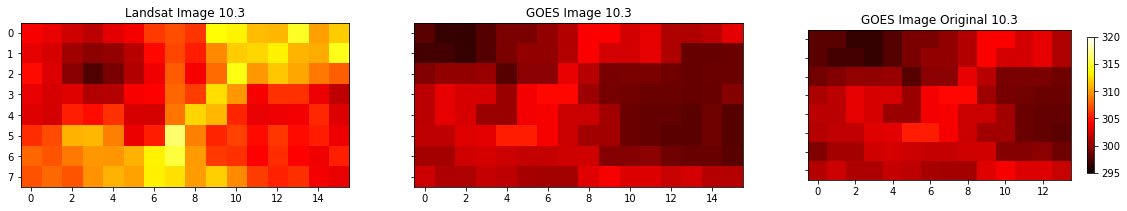

In [91]:
landsat_img_103 = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.02deg.npy'))
goes_img_103 = shiftPixels(landsat_img, goes103, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_original_103 = goes103[latsA[0]:latsA[1], lonsA[0]:lonsA[1]]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
max_temp = 320
min_temp = 295
landsat_map = ax1.imshow(landsat_img_103, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1.set_title('Landsat Image 10.3')
goes_map = ax2.imshow(goes_img_103, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2.set_title('GOES Image 10.3')
goes_original_map = ax3.imshow(goes_img_original_103, vmin = min_temp, vmax = max_temp, cmap='hot')
ax3.set_title('GOES Image Original 10.3')
plt.colorbar(landsat_map, ax = ax3, shrink=0.25)

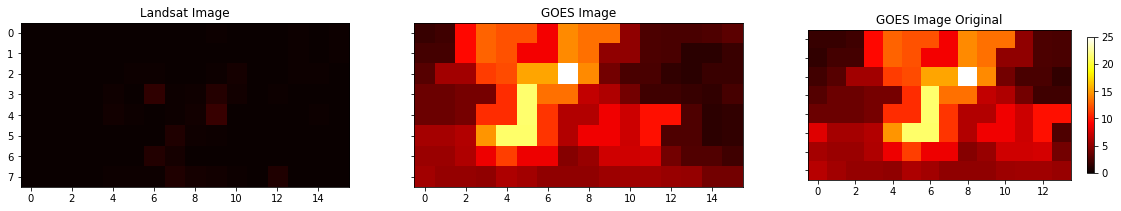

In [102]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
max_temp = 25
min_temp = 0
landsat_map = ax1.imshow(landsat_img_039-landsat_img_103, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1.set_title('Landsat Image')
goes_map = ax2.imshow(goes_img_039-goes_img_103, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2.set_title('GOES Image')
goes_original_map = ax3.imshow(goes_img_original_039-goes_img_original_103, vmin = min_temp, vmax = max_temp, cmap='hot')
ax3.set_title('GOES Image Original')
plt.colorbar(landsat_map, ax = ax3, shrink=0.25)

In [41]:
def shiftPixels(refimg, newimg_full, lats, lons):
    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    x_add = 0
    y_add = 0
    while refimg.shape != newimg.shape:
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
        newimg = newimg_full[lats[0]:lats[1] + x_add, lons[0]:lons[1] + y_add]
    lats[0] -= x_add
#     lats[1] += x_add
#     lons[0] -= y_add
    lons[1] += y_add

    n = 2
    x_shift = np.arange(-n, n+1)
    y_shift = np.arange(-n, n+1)
    scores = []
    for x in x_shift:
        for y in y_shift:
            testimg = newimg_full[lats[0]+x:lats[1]+x, lons[0]+y:lons[1]+y]
            scores.append([x, y, np.corrcoef(refimg.flatten(), testimg.flatten())[0, 1]])
            
    min_score = 1
    min_score_index = 0
    for score_index in range(len(scores)-1):
        score = scores[score_index][-1]
        if score < min_score:
            min_score = score
            min_score_index = score_index
            
    min_x, min_y, min_score = scores[min_score_index]
    return newimg_full[lats[0]+min_x:lats[1]+min_x, lons[0]+min_y:lons[1]+min_y]


In [104]:
def load_image(array):
    """
    Returns loaded .npy file.
    
    Parameter path: Path to load .npy file from
    Precondition: path is a string
    """
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= array
    result[:,:,1]= array
    result[:,:,2]= array
    return result

def preprocess_image(array):
    """
    Returns preprocessed input array.
    
    Parameter array: array to preprocess
    Precondition: array is a numpy array
    """
    hr_image = array
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    """
    Returns low resolution image after scaling down input image using nearest neighbor downsampling.

    Parameter image: 3D of 4D tensor of preprocessed image
    Precondition: image is a tensor
    """
    height, width = image.shape
    result = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))
    smallimg = resize(image, (round(height/2), round(width/2)))
    result[:,:,0] = smallimg
    result[:,:,1] = smallimg
    result[:,:,2] = smallimg
    lr_image = tf.expand_dims(result, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

def esrgan_sharpening_img(image):
    """
    Returns dictionary containing errors after using the ESRGAN model.
    
    Parameter path: path of image not including file name
    Precondition: path is a string
    
    Parameter file: file of the image
    Precondition: file is a string of a .npy file
    """
    hr_image = preprocess_image(load_image(image))
    lr_image = downscale_image(image)
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)

    hr_image = tf.squeeze(hr_image).numpy()
    lr_image = tf.squeeze(lr_image).numpy()
#     lr_image = resize(lr_image, (hr_image.shape[0], hr_image.shape[1], 3)).ravel()
#     fake_image = resize(fake_image.numpy(), (hr_image.shape[0], hr_image.shape[1], 3))

    return np.mean(fake_image, axis=2)

In [120]:
new_goes_039 = esrgan_sharpening_img(goes_img_039)
new_goes_103 = esrgan_sharpening_img(goes_img_103)
new_goes_diff = new_goes_039-new_goes_103

new_landsat_039 = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.01deg.npy'))
new_landsat_103 = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.01deg.npy'))

landsat_diff = new_landsat_039 - new_landsat_103

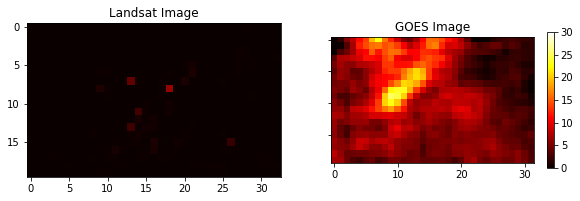

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
max_temp = 30
min_temp = 0
landsat_map = ax1.imshow(landsat_diff, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1.set_title('Landsat Image')
goes_map = ax2.imshow(new_goes_diff, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2.set_title('GOES Image')
plt.colorbar(landsat_map, ax = ax2, shrink=0.25)

In [123]:
landsat_diff.shape

(21, 33)

In [125]:
new_goes_diff.shape

(20, 32)